# Alarm-Incident Taxonomy

## Introduction

Alarms indicate exceptional states or behaviors, for example, component failures, congestion, errors, or intrusion attempts. Network monitors typically collect data at network elements and detect out of tolerance conditions and exceptions, generating appropriate alarms. Often, a single problem will be manifested through a large number of alarms. These alarms must be correlated to pinpoint their causes so that problems can be handled effectively. An event model represents knowledge of the various events and their relationships and correlates them to their causal problems. The model is meant to emphasise and reflect certain desirable properties:

* **Flexible:** It should encompass and allow for stochastic components of the alarms process, which includes but is not limited to temporal phenomena including periodicity and auto-correlation.
* **Evolutionary:** It must be sufficiently general to handle rapidly evolving network systems and scenarios, specifically in cases where certain problems that have never been observed before.
* **Scalable:** It must be scalable to large networks involving increasingly complex elements as the number of problems associated as well as the number of symptoms manifested increase exponentially.
* **Robust:** It must be resilient to noise in the inputs such as lossy (FN) or spurious (FP) observations and other inconsistencies such as incorrect/missing information.

In [1]:
import pandas as pd
import seaborn as sns
sns.set_palette("hls",n_colors=6)
%pylab inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Populating the interactive namespace from numpy and matplotlib


/home/anant/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Dataset

We evaluate our methodology for alarm correlation and prioritization from a major telecommunication network for a total duration of 10 months (2016). Alarms have been manually tagged by an experienced operator to a set of incidents that triggered those alarms. The dataset is comprised of both structured and unstructured information with everything in between. Each alarm represents a change of state broadly comprised of two key pieces of (observable) information, namely: the associated entities or context (Where?) and the associated behaviour (What? How much?).

### Assumptions

* Alarms are generated at ***create_time***, update time simply reflects updated/corrected information about the alarm but not the generation time and ***rank_order*** provides the information about ordering of the updates for a given ***alarm_id***.
* The distinction supplied by ***manually_generated*** alarms is of no significance, i.e. it makes no difference whether the alarm is manually generated or not. Similarly, severity holds no bearing on the alarm information.
* Change requests, given by a valid ***crq_id*** are associated with planned outages/maintenance and relate to known alarms which is further assumed to provide no information about any (unplanned) incidents and such cases are dropped along with all attributes associated with change requests (***crq_\****)
* Persistent alarms generated with the same set of attributes (***node***) but different ***alarm_id*** are considered separately. It is observed that multiple such alarms are generated at the same time differing in the alarm descriptions.

### Preprocessing

The following steps are taken for preprocessing:
* Drop incorrect observations (whatever formats are standardized/known)
* Mixed data type handling
* Missing value imputation (use NULL)
* Filter alarms associated with change requests (CRQ)
* Filter irrelevant columns
* Define index, attribute and measure columns

## Methodology

### Graph Representation

* **Alarm Classes:** As stated previously, an alarm is characterized by its associated entities (Where?) and its behaviour (What? How?). Both these characteristics may have complex inter-twined relationships within as well as among each other which may be exploited explicitly by using information about the network-entity and alarm-attribute topologies. We instead assume each alarm to be characterised by its unique set of attributes including its associated entities and behaviors as a single tuple. For example: an alarm described by Entities (A,B,C) and Behaviors (D,E,F) is classfied by the tuple (A,B,C,D,E,F). A classification for incidents can be done in a similar way.

* **Graph Representation:** Assume $A$ represents the set of known alarms, and $I$ the set of incidents. An alarm-incident graph for a given time-period is defined as a **weighted bipartite graph $G(A,I,E)$**, where E is a set of edges representing the observed direct relationships between alarms and incidents. The strength of the edges correspond to the observed frequency of co-occurrence between the alarm and incident classes defined above. Note that the alarms and incident classes will in general not exhibit an onto relationship given the existence of alarms not associated with an incident, rather, there is the likelihood of an incident given an alarm. Thus, we introduce the notion of a "NULL" incident class, $I_{\phi}$ denoting that no incident was observed. Two scenarios emerge as a result, first, where the alarm-incident graph is conditional on the fact that an incident has occurred and excludes $I_{\phi}$ along with all the alarms not associated with any incident. Second, where the complete graph includes $I_{\phi}$ and all alarms. We evaluate our methodology for both these scenarios.

In [5]:
%%time
node_topology = [col for col in alarms_clean.columns if "node" in col]
alarm_attributes = ['message_source_name', 'application', 'message_group', 'object', 'service_name',\
                    'alarm_instruction_number', 'alarm_product']
alarms_clean['incident'] = 0
alarms_clean.loc[alarms_clean['incident_id']<>"NULL","incident"] = 1
alarms_clean['count'] = 1
alarm_classes = alarms_clean.groupby(alarm_attributes)['count'].sum().order(ascending=False).reset_index()[alarm_attributes].T.to_dict()
alarm_inverted = {tuple(v.values()):k for k,v in alarm_classes.iteritems()}
key_order = alarm_classes[0].keys()
alarms_clean['class'] = alarms_clean[key_order].apply(lambda x: alarm_inverted[tuple(x)],axis=1)

alarms_clean['timestamp'] = pd.to_datetime(alarms_clean["create_time"],format="%Y%m%d%H%M%S")
alarms_clean.sort(['class','timestamp'],inplace=True)
prev = alarms_clean[['timestamp','class']].subtract(alarms_clean.shift()[['timestamp','class']])
prev['timestamp'] = prev['timestamp'].astype("timedelta64[s]")
prev.loc[prev['class']==1,"timestamp"] = np.nan
alarms_clean['time_diff'] = prev['timestamp']

/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)
/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


CPU times: user 47.5 s, sys: 311 ms, total: 47.8 s
Wall time: 47.8 s


## Representation

Multiple groupings discovered based on considering different sets of input features are illustrated below. We compute similarities between alarm and incident classes using SimRank++ on a bipartite graph for the following scenarios of input classes:

    * Including NULL class
    * Exluding NULL class
        * Complete feature set
        * Minimal feature set
        * Balanced feature set

In [7]:
# Split data
split_date = "2016-07-20"
alarms_train = alarms_clean[alarms_clean['timestamp']<split_date]
inc_train = incidents_filt[incidents_filt['timestamp']<split_date]

temp = alarms_train.groupby("class")['incident'].sum()
null_alarms = temp[temp==0].index
alarms_train['alarm_inc_class'] = alarms_train['class']
alarms_train.loc[alarms_train['class'].isin(null_alarms),"alarm_inc_class"] = -1

print "%s date split fractions for alarms: %0.02f; incidents: %0.02f"%(split_date,len(alarms_train)/float(len(alarms_clean)),len(inc_train)/float(len(incidents_filt)))

ai_classmap = pd.concat({"inc_class":alarms_train['incident_id'].map(inc_train['class']).fillna(-1),"alarm_class":alarms_train['alarm_inc_class']},axis=1)
ai_classmap['count'] = 1

# Graph including NULL classes
ai_mat = ai_classmap.groupby(['alarm_class','inc_class'])['count'].sum().unstack()
ai_mat.columns = "inc_"+ai_mat.columns.astype("int64").astype("str")
ai_mat.index = "alarm_"+ai_mat.index.astype("int64").astype("str")
#thres = 100
#ai_mat = ai_mat.applymap(lambda x: thres if x>thres else x)
ai_mat.stack().to_csv("data/ai_bipart_null",header=False)
print "Bipartite graph (A,I,E) including NULL classes: (%d,%d,%d)"%(len(ai_mat.index),len(ai_mat.columns),len(ai_mat.stack()))

# Graph excluding NULL classes
ai_mat_ = ai_mat.drop("alarm_-1").drop("inc_-1",axis=1)
ai_mat_.stack().to_csv("data/ai_bipart",header=False)
print "Bipartite graph (A,I,E) excluding NULL classes: (%d,%d,%d)"%(len(ai_mat_.index),len(ai_mat_.columns),len(ai_mat_.stack()))

/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anant/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2016-07-20 date split fractions for alarms: 0.79; incidents: 0.82
Bipartite graph (A,I,E) including NULL classes: (656,313,1291)
Bipartite graph (A,I,E) excluding NULL classes: (655,312,713)


## Distance

A real function d(a,b) is a distance metric if it is symmetric, non-negative and satisfies the triangle inequality. Additionally, we define a semi-ring on the graph with an order and two operations \*(catenation) and \+(combination) such that it is consistent with the distance metric assumptions. The graph structure can be exploited to compute the distance (given the path) between two alarms (A,B) as the conditional probability of reaching B given starting node A. This leads to defining the catenation operation as the product of transition probabilities for a chain while the combination operation is defined as the sum of probabilities for various paths. Symmetry is imposed by defining distance as the product of conditional probabilities from A to B and back from B to A :

* $d(a,a)=0$;
* $d(a,b)\ge 0$;
* $d(a,c)\le d(a,b)+d(b,c)$

**SimRank:** is a general similarity measure, based on a simple and intuitive graph-theoretic model. SimRank is applicable in any domain with object-to-object relationships, that measures similarity of the structural context in which objects occur, based on their relationships with other objects. Effectively, SimRank is a measure that says two objects are considered to be similar if they are referenced by similar objects.

Let the set of alarms be represented as $A$, and incidents as $I$ denoting nodes in the bipartite graph $G(A,I,E)$. $E$ is the set of (undirected) edges connecting alarms-incidents. Given an alarm/incident denoted $x$, then $I(x)$ is the set of neighbors of $x$, eg, if $x$ is an alarm, then $I(x)$ is the set of incidents associated with the alarm and vice-versa and $N(x)$ denotes the number of neighbors of $x$. For alarms/incidents $a$ and $b$, similarity $s(a,b)$ is given as:

$$s_{k+1}(a,b)={\frac {C}{\left|I(a)\right|\left|I(b)\right|}}\sum _{i=1}^{\left|I(a)\right|}\sum _{j=1}^{\left|I(b)\right|}s_{k}(I_{i}(a),I_{j}(b))$$

$$s_{0}(a,b)={\begin{cases}1{\mbox{  }},{\mbox{    }}{\mbox{if }}a=b{\mbox{  }},\\0{\mbox{  }},{\mbox{    }}{\mbox{if }}a\neq b{\mbox{  }}.\end{cases}}$$

where $C$ is a constant between $[0,1]$. In case there are no common neighbors between $a$ and $b$, then there is no way to infer similarity, which is then set to $s(a,b)=0$.

SimRank does not directly take into account the number of common neighbors (evidence) and strength of the edges (weights) in computing the similarities, and can be generalized to accomodate these by way of slight modifications in an improved version, **SimRank++**. Note that both these measures are bounded between [0,1] and can be shown to follow the triangle inequality.

We invert the notion of similarity, $s$ to define dissimilarity/distance as $d=1-s$. The similarity measures do not obey the triangle inequality axiom of distance which implies that if objects a and b are close and objects b and c are close, then objects a and c must also be close. As stated previously, we choose to evaluate SimRank++ for two scenarios, inclusive of NULL classes in alarms/incidents bipartite graph as well as exclusive.

In [30]:
import subprocess
import readline
import rpy2
from time import time
from sklearn import manifold

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%time
K = 6
C = 0.5
cmd = 'scripts/bipartite_distance ' + str(K) + ' ' + str(C) + ' data/ai_bipart_null'
print cmd
bipartite_out = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE).communicate()[0]

scripts/bipartite_distance 5 0.5 data/ai_bipart_null
CPU times: user 166 ms, sys: 120 ms, total: 286 ms
Wall time: 43min 31s


In [13]:
sim_bipart = [b.split(',') for b in bipartite_out.split('\n')][:-1]
sim_mat = pd.DataFrame(sim_bipart,columns=['entity_a','entity_b','similarity'])
sim_mat['similarity'] = sim_mat['similarity'].astype("float64")
alarm_sim = sim_mat[np.logical_and(sim_mat['entity_a'].str.contains("alarm_"),sim_mat['entity_b'].str.contains("alarm_"))]
alarm_sim['distance'] = 1-alarm_sim['similarity']
alarm_dist = alarm_sim.groupby(['entity_a','entity_b'])['distance'].max().unstack().sort_index().sort_index(axis=1)
inc_sim = sim_mat[np.logical_and(sim_mat['entity_a'].str.contains("inc_"),sim_mat['entity_b'].str.contains("inc_"))]
inc_sim['distance'] = 1-inc_sim['similarity']
inc_dist = inc_sim.groupby(['entity_a','entity_b'])['distance'].max().unstack().sort_index().sort_index(axis=1)

/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
%%time
K = 30
C = 0.5
cmd = 'scripts/bipartite_distance ' + str(K) + ' ' + str(C) + ' data/ai_bipart'
print cmd
bipartite_out = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE).communicate()[0]

sim_bipart = [b.split(',') for b in bipartite_out.split('\n')][:-1]
sim_mat_ = pd.DataFrame(sim_bipart,columns=['entity_a','entity_b','similarity'])
sim_mat_['similarity'] = sim_mat_['similarity'].astype("float64")
alarm_sim = sim_mat_[np.logical_and(sim_mat_['entity_a'].str.contains("alarm_"),sim_mat_['entity_b'].str.contains("alarm_"))]
alarm_sim['distance'] = 1-alarm_sim['similarity']
alarm_dist = alarm_sim.groupby(['entity_a','entity_b'])['distance'].max().unstack().sort_index().sort_index(axis=1)
inc_sim = sim_mat_[np.logical_and(sim_mat_['entity_a'].str.contains("inc_"),sim_mat_['entity_b'].str.contains("inc_"))]
inc_sim['distance'] = 1-inc_sim['similarity']
inc_dist = inc_sim.groupby(['entity_a','entity_b'])['distance'].max().unstack().sort_index().sort_index(axis=1)
%Rpush alarm_dist

scripts/bipartite_distance 30 0.5 data/ai_bipart


/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 5.34 s, sys: 321 ms, total: 5.66 s
Wall time: 3min 23s


/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MDS Stress: 28894.49
MDS Stress: 2967.56


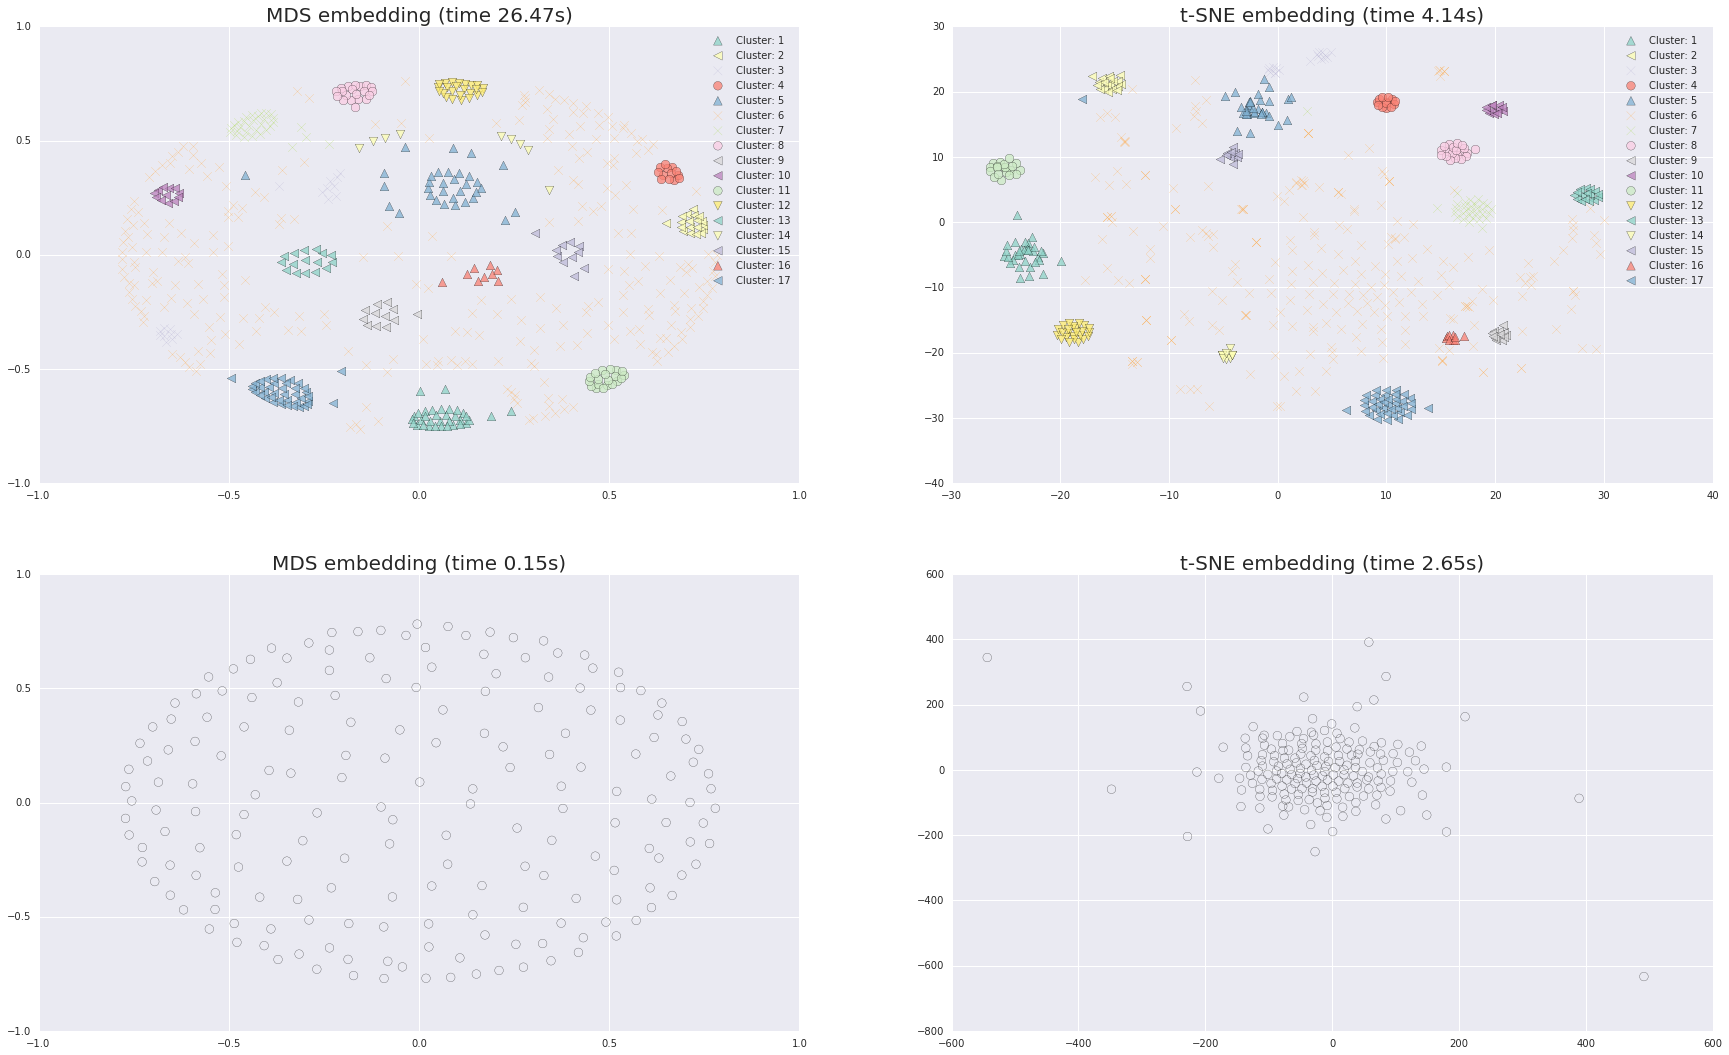

In [135]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("Set2", 10))

fig, axes = plt.subplots(2,2,figsize=(30,18))
np.random.seed(1)
k = 17
method="ward.D"
clusters = np.array(clus_mat_simrank[clus_mat_simrank['opt_k']==k][clus_mat_simrank['objective']==method]['clusters'].values[0])
cmap = ListedColormap(sns.color_palette("Set3", k))
markers = np.random.choice(['x','o','v','^','<'],k)

i=0
def plot_embedding(X,title,i=i,colors=[]):
    k,j = i/2,i%2
    alpha,s = 0.75,75
    if len(colors)<>0:
        for color in set(colors): 
            axes[k][j].scatter(X[colors==color,0],X[colors==color,1],s=s,alpha=alpha,c=cmap.colors[color-1],\
                               label="Cluster: %s"%color,marker=markers[color-1])
    else: axes[k][j].scatter(X[:,0],X[:,1],s=s,alpha=alpha,c=colors)
    axes[k][j].set_title(title,fontsize=20)
    axes[k][j].legend()
    i+=1
    return i

#----------------------------------------------------------------------
# MDS embedding
mds = manifold.MDS(n_components=2, n_init=5, max_iter=100000,dissimilarity='precomputed')
t0 = time()
X_mds = mds.fit_transform(alarm_dist.values)
print("MDS Stress: %0.2f" % mds.stress_)
i = plot_embedding(X_mds[:,:2],"MDS embedding (time %.2fs)" %(time() - t0),i,colors=clusters)

#----------------------------------------------------------------------
# t-SNE embedding
tsne = manifold.TSNE(n_components=2,learning_rate=1000,metric='precomputed')
t0 = time()
X_tsne = tsne.fit_transform(alarm_dist.values)
i = plot_embedding(X_tsne[:,:2],"t-SNE embedding (time %.2fs)" %(time() - t0),i,colors=clusters)

#----------------------------------------------------------------------
# MDS embedding
mds = manifold.MDS(n_components=2, n_init=1, eps=1e-10, max_iter=10000,dissimilarity='precomputed')
t0 = time()
X_mds = mds.fit_transform(inc_dist.values)
print("MDS Stress: %0.2f" % mds.stress_)
i = plot_embedding(X_mds[:,:2],"MDS embedding (time %.2fs)" %(time() - t0),i)

#----------------------------------------------------------------------
# t-SNE embedding
tsne = manifold.TSNE(n_components=2,learning_rate=1000,metric='precomputed')
t0 = time()
X_tsne = tsne.fit_transform(inc_dist.values)
i = plot_embedding(X_tsne[:,:2],"t-SNE embedding (time %.2fs)" %(time() - t0),i)

It is observed that many instances could not be clustered (yellow crosses) as a result of certain limitations in the similarity considered. This is especially the case for the observed long-tail in both the alarm and incident classes which are infrequent but many, which implies the absence of common neighbors between those instances and hence remain unclustered. In order to alleviate this sort of sparse neighborhood issue, we introduce the notion of a similarity "induced" in the input attribute space using the "good" clusters, i.e. of those instances that could be clustered well (non-yellow crosses).

### Induction

Map the clusters $\{C_i\}$ to the input space with the set of attributes denoted by $\mathbf {x} =(x_{1},\dots ,x_{n}) \in {R^{n}} $, define similarity between input attributes and each of the $k$ clusters so obtained as: $$s = p(C\mid \mathbf {x})$$

*Note: the following is contingent on the quality of clustering which implicitly depends on the premature choice of $k$ and the clustering scheme.*

**Classification:** Given this definition of similarity, we seek to obtain probabilities of the respective class/cluster labels for each input sample, $\mathbf {x} \in R^{n}$. This probability may also be interpreted as a confidence score on the predictions of a classifier. As a minimalistic example using a naive bayes classifier, the conditional probability can be decomposed as: $$p(C_{i}|\mathbf {x})={\frac {p(C_{i})\ p(\mathbf {x} | C_{i})}{p(\mathbf {x} )}}$$ 

Under the naive independence assumption, the conditional distribution over the class variable is given as: $$p(C_{i}|\mathbf {x}) = p(C_{i})\prod _{j=1}^{n}p(x_{j}| C_{i})$$

The subsequent analysis evaluates a **random forest classifier** because of its superior accuracy with minimal tuning and natural ability of handling categorical data.

**Calibration:** Well calibrated classifiers output characteristic scores that can directly be interpreted as class probabilities. Logistic Regression returns well calibrated predictions by default as it directly optimizes log-loss. In contrast, the other methods return biased probabilities; Their predictions can be calibrated using parametric approaches based on Platt’s sigmoid model, and non-parametric approaches based on isotonic regression. Probability calibration should be done on unseen data, ideally through cross validation on multiple folds.

**Distance:** Our measure of similarity is defined on a probabilistic space describing a measure of distance between an observation (alarm-class) and a cluster. Distances amongst observations can then be formulated from the broad class of statistical distances, most noteworthy of those being information theoretic measures such as the Kullback-Liebler divergence. However, most of these distances do not qualify as a metric since they are not symmetric in general, and frequently violate the triangle inequality. One notable variant which does obey the metric assumptions is the **Hellinger Distance**.

For two discrete probability distributions $P=(p_{1},\ldots ,p_{k})$ and $Q=(q_{1},\ldots ,q_{k})$, their Hellinger distance is defined as

$$H(P,Q)={\frac {1}{\sqrt {2}}}\;{\sqrt {\sum _{i=1}^{k}({\sqrt {p_{i}}}-{\sqrt {q_{i}}})^{2}}}$$

We present a qualitative visual analysis of the developed taxonomy for two scenarios in the following exercise. 

1. Excluding common attributes between alarms and incidents for defining incident classes, such as "product_topology", 2. Including all incident attributes for defining incident classes. 

Some of the trade-offs between the objectives and parameters considered include:

* Clustering: parameters include alarm/incident class attributes, distance metric, clustering algorithm and choice of "k"
    * Quality: using multiple cluster heuristics; silhouette, cindex, information theoretic, etc.
    * Coverage: # instances clustered vs. not
* Classification: parameters include clustering quality/coverage, choice of classifier, calibration method, distance metric
    * Accuracy, f1 score

### 1. Excluding common attributes

In [136]:
clusters = pd.Series(index=alarm_dist.index,data=clusters,name="cluster").sort_index()
inp = pd.DataFrame({"alarm_"+str(i):alarm_classes[i] for i in clusters.index.str.split("_").str[1].astype("int64")}).T
numcols = ['alarm_instruction_number']
nums = inp[numcols].convert_objects(convert_numeric=True).fillna(-1).astype("float64")

to_dummies = [col for col in inp.columns if col not in nums]
cats = pd.concat([pd.get_dummies(inp[[col]]).iloc[:,:-1] for col in to_dummies],axis=1)
data = pd.concat([cats,nums],axis=1)
drop_clus = 6
clus_filt = clusters[clusters<>drop_clus]
clus_clas_map = dict(zip(sort(clus_filt.unique()),range(len(sort(clus_filt.unique())))))
y = clus_filt.replace(clus_clas_map).ix[clus_filt.index]
X = data.ix[clus_filt.index]
X_train = pd.concat([X[y==k].sample(frac=0.7) for k in y.unique()])
y_train = y.ix[X_train.index]
X_test, y_test = X.drop(X_train.index), y.drop(X_train.index)
print "number of samples, features (excluding unclustered): %d,%d"%X.shape
print "output classes: %s"%sort(y_train.unique())

number of samples, features (excluding unclustered): 322,884
output classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [137]:
%%time

# Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.5, penalty="l1", dual=False).fit(X, y)
f_select = SelectFromModel(lsvc, prefit=True)
X_select_train = f_select.transform(X_train)
X_select_test = f_select.transform(X_test)
X_select = f_select.transform(X)
print "# training samples, # features selected : %d,%d"%X_select.shape

# Grid search hyper-parameter estimation followed by calibration (5-fold CV)
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
np.random.seed(1)

est = RandomForestClassifier()
# specify parameters and distributions
param_grid = {"n_estimators":[100],"max_depth":[3,5,7,10,None],"min_samples_split":[3,5,7,10],"bootstrap":[True,False],\
              'criterion':['gini','entropy']}

metrics = ['accuracy','f1_weighted','f1_micro']
clf = {}
for metric in metrics:
    # Before
    clf[metric] = GridSearchCV(est, param_grid=param_grid, cv=5, scoring=metric)
    clf[metric].fit(X_select_train, y_train)
    print "\nHyper-parameters on 5-fold CV: %s; \n%s: %0.02f"%(clf[metric].best_params_,metric,clf[metric].best_score_)
    print "Uncalibrated log-loss on test data: %0.3f"%log_loss(y_test,clf[metric].predict_proba(X_select_test))

    # After
    est = RandomForestClassifier(**clf[metric].best_params_)
    for method in ['sigmoid']:
        cal = CalibratedClassifierCV(base_estimator=clf[metric].best_estimator_, cv="prefit", method=method)
        cal.fit(X_select_test,y_test)
        print "Calibrated log-loss on test data (%s): %0.3f"%(method,log_loss(y_test,cal.predict_proba(X_select_test)))
        cal2 = CalibratedClassifierCV(base_estimator=est, cv=5, method=method)
        cal2.fit(X_select,y)
        print "Calibrated log-loss with 5-fold CV (%s): %0.3f"%(method,log_loss(y,cal.predict_proba(X_select)))

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p)-np.sqrt(q))**2))/np.sqrt(2)

from scipy import spatial
prob = cal2.predict_proba(f_select.transform(data[X.columns]))
new_dist = spatial.distance.squareform(spatial.distance.pdist(prob,hellinger))
%Rpush new_dist

# training samples, # features selected : 322,260

Hyper-parameters on 5-fold CV: {'min_samples_split': 3, 'n_estimators': 100, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': None}; 
accuracy: 0.67
Uncalibrated log-loss on test data: 1.587
Calibrated log-loss on test data (sigmoid): 1.100
Calibrated log-loss with 5-fold CV (sigmoid): 0.625

Hyper-parameters on 5-fold CV: {'min_samples_split': 5, 'n_estimators': 100, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None}; 
f1_weighted: 0.65
Uncalibrated log-loss on test data: 1.899
Calibrated log-loss on test data (sigmoid): 1.093
Calibrated log-loss with 5-fold CV (sigmoid): 0.606

Hyper-parameters on 5-fold CV: {'min_samples_split': 7, 'n_estimators': 100, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None}; 
f1_micro: 0.67
Uncalibrated log-loss on test data: 1.854
Calibrated log-loss on test data (sigmoid): 1.084
Calibrated log-loss with 5-fold CV (sigmoid): 0.627
CPU times: user 6min 11s, sys: 276 ms, tot

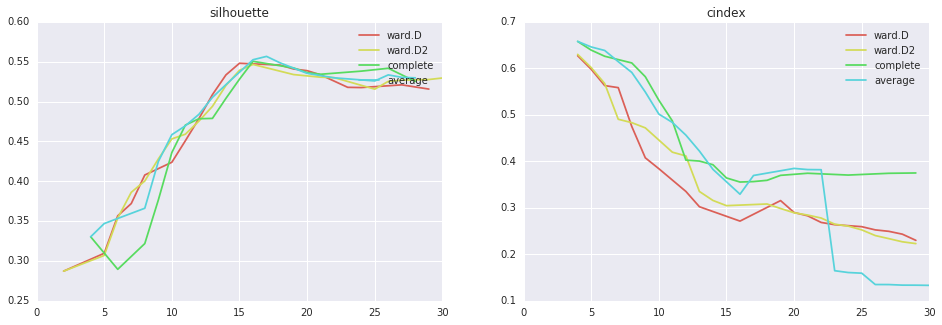

In [140]:
%Rpull out
k_max = 30
fig,axes = plt.subplots(1,2,figsize=(16,5))
clus_mat_hellinger = pd.concat([pd.DataFrame(list(ou[:2]) for ou in out),pd.DataFrame(list(ou[2]) for ou in out)],axis=1).applymap(list)
clus_mat_hellinger.columns = ['metric','objective','values','opt_','clusters']
for col in ['metric','objective']:
    clus_mat_hellinger[col] = clus_mat_hellinger[col].str[0]
clus_mat_hellinger['opt_k'] = clus_mat_hellinger['opt_'].str[0]
clus_mat_hellinger['opt_v'] = clus_mat_hellinger['opt_'].str[1]
i=0
methods = ["ward.D", "ward.D2", "complete", "average"]
for met in ['silhouette','cindex']:
    sub = clus_mat_hellinger[clus_mat_hellinger['metric']==met]
    for method in methods:
        axes[i].plot(sub[sub['objective']==method]['opt_k'],sub[sub['objective']==method]['opt_v'],label=method)
        axes[i].legend(), axes[i].set_title(met)
    i+=1

/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MDS Stress: 4256.894406


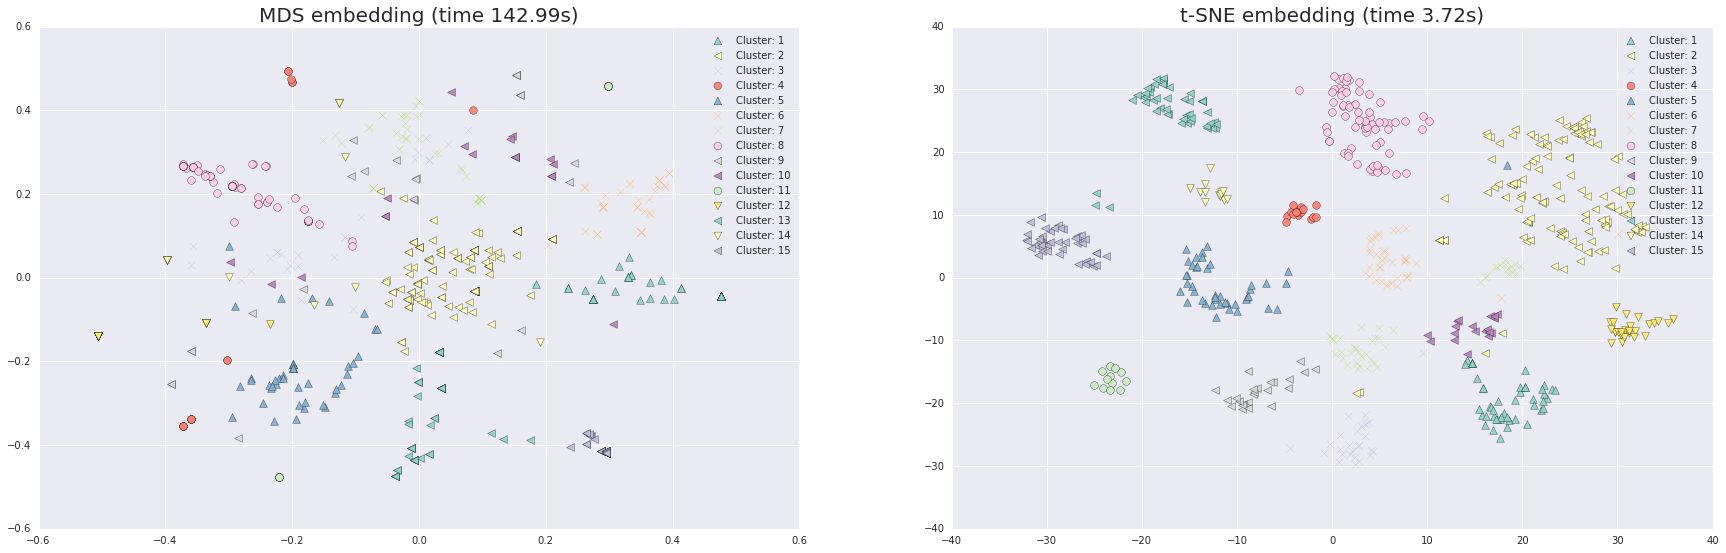

In [148]:
fig, axes = plt.subplots(1,2,figsize=(30,9))
np.random.seed(1)
k = 15
method="ward.D"
%Rpull out
clusters = np.array(clus_mat_hellinger[clus_mat_hellinger['opt_k']==k][comparison['objective']==method]['clusters'].values[0])
cmap = ListedColormap(sns.color_palette("Set3", k))
markers = np.random.choice(['x','o','v','^','<'],k)

i=0
def plot_embedding(X,title,i=i,colors=[]):
    k,j = i/2,i%2
    alpha,s = 0.95,60
    if len(colors)<>0:
        for color in set(colors):
            axes[i].scatter(X[colors==color,0],X[colors==color,1],s=s,alpha=alpha,c=cmap.colors[color-1],\
                               label="Cluster: %s"%color,marker=markers[color-1])
    else: axes[i].scatter(X[:,0],X[:,1],s=s,alpha=alpha,c=colors)
    axes[i].set_title(title,fontsize=20)
    axes[i].legend()
    i+=1
    return i

#----------------------------------------------------------------------
# MDS embedding
mds = manifold.MDS(n_components=2, n_init=10, max_iter=10000, eps=1e-10, dissimilarity='precomputed')
t0 = time()
X_mds = mds.fit_transform(new_dist)
print("MDS Stress: %f" % mds.stress_)
i = plot_embedding(X_mds,"MDS embedding (time %.2fs)" %(time() - t0),i,colors=clusters)

#----------------------------------------------------------------------
# t-SNE embedding
tsne = manifold.TSNE(n_components=2,learning_rate=1100,metric='precomputed')
t0 = time()
X_tsne = tsne.fit_transform(new_dist)
i = plot_embedding(X_tsne[:,:2],"t-SNE embedding (time %.2fs)" %(time() - t0),i,colors=clusters)

In [303]:
taxonomy = pd.Series(clusters,index=alarm_dist.index)
alarm_inc_train = alarms_train[alarms_train['incident_id'].isin(list(inc_train.index)+['NULL'])]
alarm_inc_train['cluster_id'] = alarm_inc_train['alarm_inc_class'].apply(lambda x: "alarm_"+str(x)).map(taxonomy).fillna(0)
drop = ['count','class','time_diff']
alarm_inc_train.drop(drop,axis=1).to_csv("data/alarm_taxonomy")

/home/anant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Evaluation

We observe marked differences between the first-level of clustering (using SimRank) as a result of varying the set of input attributes used for defining the incident classes, both in terms of quality as well as coverage of the clusters. For a given arbitrary but fixed number of clusters "k", on the one hand, including more attributes in the incident class definitions is accompanied with a loss of clustering coverage in terms of the fraction of instances that could be clustered, while maintaining SSE, inter/intra cluster distance etc. On the other hand, including more attributes is also accompanied with an increase in classification quality, i.e measured as 5-fold cross validated accuracy and f1-score. This can be explained as follows: as the number of input attributes considered increase, the neighborhood sparsity in the bipartite graph also increases which has a direct consequence on the clustering so obtained from SimRank, which in general led to smaller clusters thus reducing coverage. However, including more attributes also led to an increase in the number of common attributes between the alarms and incidents thus creating a positive impact on classification accuracy. This trade-off might be considered for defining some notion of optimality in the various input parameters (such as "k").

# References

* https://en.wikipedia.org/wiki/SimRank
* G. Jeh and J. Widom. SimRank: A Measure of Structural-Context Similarity: http://www-cs-students.stanford.edu/~glenj/simrank.pdf
* I. Antonellis, H. Garcia-Molina and C.-C. Chang. Simrank++: Query Rewriting through Link Analysis of the Click Graph: http://ilpubs.stanford.edu:8090/868/1/2007-32.pdf